# Answering Business Questions using SQL

## Index

 * [Intro](#Intro)
 * [Import libraries and read data](#Import-libraries-and-read-data) 
 * [Selecting Albums to Purchase](#selecting-albums-to-purchase)
 * [Analyzing Employee Sales Performance](#Analyzing-Employee-Sales-Performance)

---
## <a id='intro'></a> Intro
[Back](#Index)

In this project, we're going to use the Chinook database. The Chinook database is provided as a SQLite database file called `chinook.db`, A copy of the database schema is below:

![Alt text](chinook-schema.svg)

---
## <a id='Import-libraries-and-read-data'></a> Import libraries and read data
[Back](#Index)

In [1]:
import sqlite3
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
blue = (0, 107/255, 164/255)
orange = (1, 128/255, 14/255)
red = (200/255, 52/255, 0/255)
light_orange = (255/255, 188/255, 121/255)

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)
        
def show_tables():
    return run_query('''
        SELECT
            name,
            type
        FROM sqlite_master
        WHERE type IN ("table","view");
    ''')
    
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


---
## <a id="selecting-albums-to-purchase"></a> Selecting Albums to Purchase
[Back](#Index)

The Chinook record store has just signed a deal with a new record label, and we've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

| Artist Name          | Genre   |
|:--------------------:|:-------:|
| Regal	               | Hip-Hop |
| Red Tone	           | Punk    |
| Meteor and the Girls | Pop     |
| Slim Jim Bites	   | Blues   |

The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [3]:
results = run_query('''
    WITH from_usa AS (
        SELECT il.*
        FROM invoice_line il
        INNER JOIN invoice i ON i.invoice_id == il.invoice_id
        WHERE i.billing_country == 'USA'
    )

    SELECT 
        g.name, 
        COUNT(t.track_id) tracks_purchased,
        CAST(COUNT(t.track_id) AS FLOAT)/
            (SELECT COUNT(*) FROM from_usa) tracks_purchased_ratio
    FROM from_usa u
    INNER JOIN track t ON t.track_id == u.track_id
    INNER JOIN genre g ON g.genre_id == t.genre_id
    GROUP BY t.genre_id
    ORDER BY tracks_purchased DESC
''');
results

,name,tracks_purchased,tracks_purchased_ratio
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Pop,22,0.020932
7,Latin,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


In [4]:
results.set_index('name', drop=True, inplace=True)

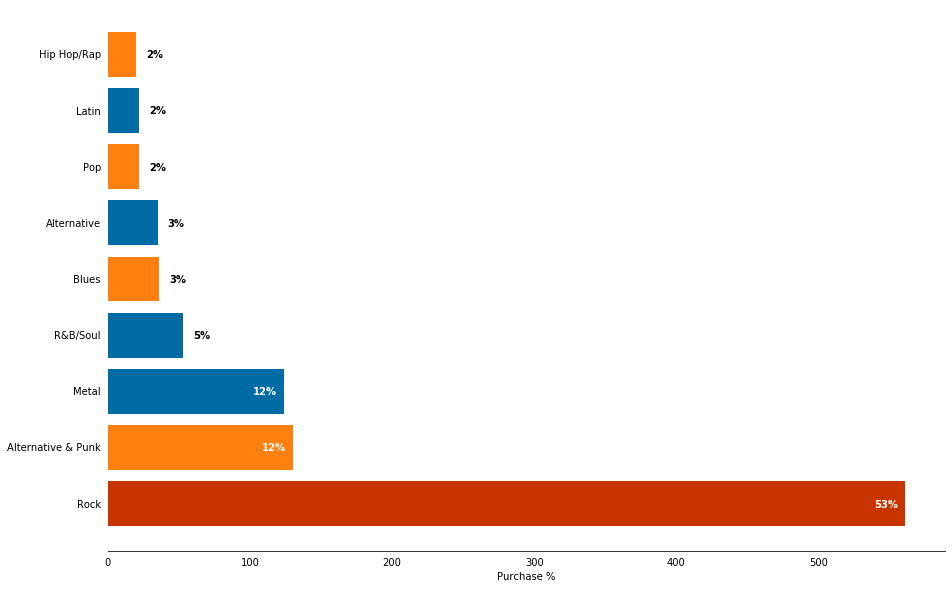

In [5]:
results['tracks_purchased_percent'] = round(results['tracks_purchased_ratio']*100).astype(int)

to_graph = results[results['tracks_purchased_percent']>1]
given_genres = ['Hip Hop/Rap', 'Alternative & Punk', 'Pop', 'Blues']

colors = []
for i, label in enumerate(list(to_graph.index)):
    if label in given_genres:
        colors.append(orange)
    else:
        colors.append(blue)
colors[0] = red

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
ax.barh(
    to_graph.index, 
    to_graph.loc[:, ['tracks_purchased']]['tracks_purchased'].tolist(), 
    color=colors)

plt.tick_params(bottom = False, left = False, labelbottom = True)

for i, label in enumerate(list(to_graph.index)):
    score = to_graph.loc[label, "tracks_purchased"]
    percent = to_graph.loc[label, 'tracks_purchased_percent']
    percent_str = to_graph.loc[label, 'tracks_purchased_percent'].astype(str)+'%'
    if percent > 10:
        plt.annotate(percent_str, (score-22, i-0.07), weight='bold', color='w')
    else:
        plt.annotate(percent_str, (score+7, i-0.07), weight='bold')
    
ax.set_xlabel('Purchase %')
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.axes.get_yaxis().get_label().set_visible(False)

plt.show()

Surely the most purchased genres, between the ones associated with the artists of the new record label (orange), are in a descent order `Alternative & Punk` (12%), `Blues` (3%) and `Pop` (2%).

However is important to notice that while these top three are, together, only the 17% of the purchases, `Rock` alone rapresent more than half of all purchases from USA.

---
## <a id='Analyzing-Employee-Sales-Performance'></a> Analyzing Employee Sales Performance
[Back](#Index)

Each customer for the Chinook store gets assigned to a sales support agent within the company when they first make a purchase. We've to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others.

In [45]:
results = run_query('''

    WITH tracks AS (
        SELECT t.track_id, il.invoice_id, t.name, g.name genre 
        FROM track t
        INNER JOIN invoice_line il ON il.track_id == t.track_id
        INNER JOIN genre g ON g.genre_id == t.genre_id
    )

    SELECT 
        e.first_name || ' ' || e.last_name support_agent, 
        e.hire_date,
        SUM(i.total) total, 
        MIN(i.invoice_date) from_date, 
        MAX(i.invoice_date) to_date
    FROM employee e
    INNER JOIN customer c ON c.support_rep_id == e.employee_id
    INNER JOIN invoice i ON i.customer_id == c.customer_id
    GROUP BY e.employee_id
''')

results

,support_agent,hire_date,total,from_date,to_date
0,Jane Peacock,2017-04-01 00:00:00,1731.51,2017-01-03 00:00:00,2020-12-30 00:00:00
1,Margaret Park,2017-05-03 00:00:00,1584.00,2017-01-05 00:00:00,2020-12-29 00:00:00
2,Steve Johnson,2017-10-17 00:00:00,1393.92,2017-01-10 00:00:00,2020-12-20 00:00:00
